In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier


# Load your dataset
df = pd.read_csv('/content/log2.csv')

In [ ]:
# Overview of the dataset
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [ ]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values (impute with mean)
# df.fillna(df.mean(), inplace=True)

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64


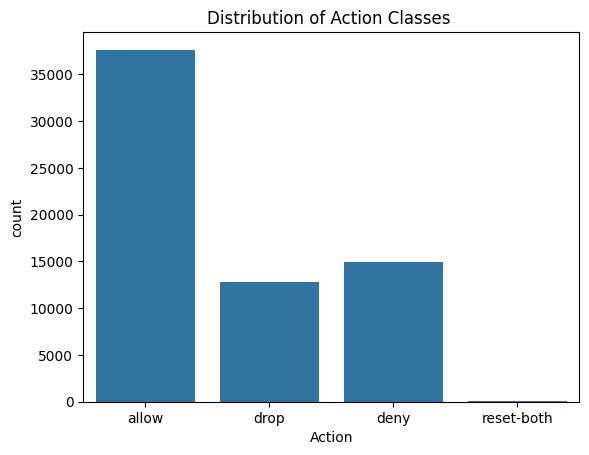

In [ ]:
# Explore categorical variables
plt.title('Distribution of Action Classes ')
sns.countplot(x=df['Action'], data=df)
plt.show()

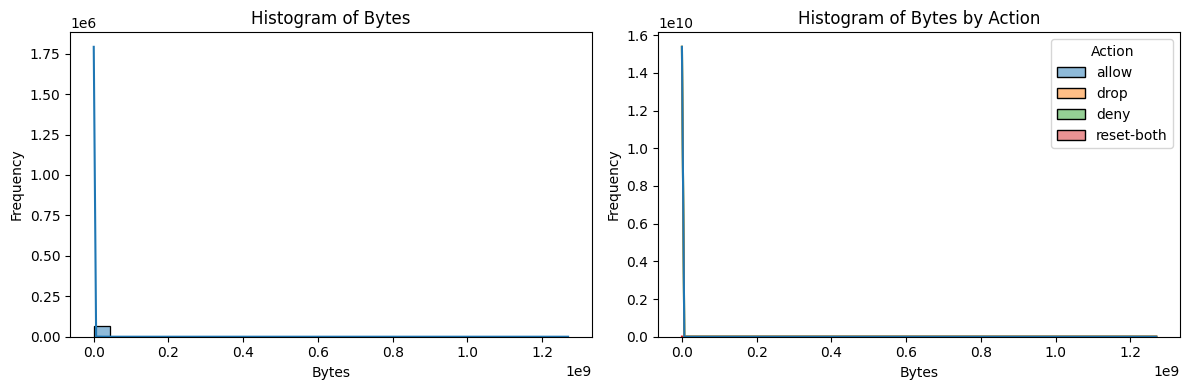

In [ ]:
# Visualize numerical variables
# Set up a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram
sns.histplot(df['Bytes'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Bytes')
axes[0].set_xlabel('Bytes')
axes[0].set_ylabel('Frequency')

# Use displot for a more flexible histogram
sns.histplot(data=df, x='Bytes', bins=30, kde=True, hue='Action', multiple='stack', ax=axes[1])
axes[1].set_title('Histogram of Bytes by Action')
axes[1].set_xlabel('Bytes')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Comprehensive summary statistics using describe
print("Summary Statistics for Bytes by Action:\n", df.groupby('Action')['Bytes'].describe())

Summary Statistics for Bytes by Action:
               count           mean           std   min     25%    50%     75%  \
Action                                                                          
allow       37640.0  169037.953241  7.412625e+06  60.0  194.00  422.0  5166.0   
deny        14987.0      83.211717  8.857610e+01  60.0   62.00   66.0    66.0   
drop        12851.0      68.675278  1.882625e+00  66.0   66.00   70.0    70.0   
reset-both     54.0     157.351852  8.132399e+01  62.0   88.75  145.0   158.5   

                     max  
Action                    
allow       1.269359e+09  
deny        1.850000e+03  
drop        7.000000e+01  
reset-both  2.930000e+02  


In [ ]:
# Extract features (X) and target variable (y)
features = df.drop(columns=['Action'])
target = df['Action']

# Encode the categorical target variable using LabelEncoder
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_target, test_size=0.2, random_state=42)

# Optionally, you can convert y_train and y_test back to their original labels
# decoded_y_train = label_encoder.inverse_transform(y_train)
# decoded_y_test = label_encoder.inverse_transform(y_test)

In [ ]:
# Define labels
labels = target.unique().tolist()
labels

['allow', 'drop', 'deny', 'reset-both']

In [ ]:
def plot_confusion_precision_recall(y_true, y_pred, labels):
    # Calculate confusion matrix, precision, and recall for each class
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)

    # Set up a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot confusion matrix using heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('Original Labels')

    # Plot precision for each class
    axes[1].bar(labels, precision, color='skyblue')
    axes[1].set_title('Precision for Each Class')
    axes[1].set_xlabel('Classes')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True)

    # Plot recall for each class
    axes[2].bar(labels, recall, color='skyblue')
    axes[2].set_title('Recall for Each Class')
    axes[2].set_xlabel('Classes')
    axes[2].set_ylabel('Recall')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True)

    # Rotate y-axis labels in the heatmap
    plt.setp(axes[0].get_yticklabels(), rotation=0)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_confusion_precision_recall(y_test, y_test_preds, labels)

Log loss on Train Data using DummyClassifier Model: 0.9820311297884631
Log loss on Test Data using DummyClassifier Model: 0.9779305507885768



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


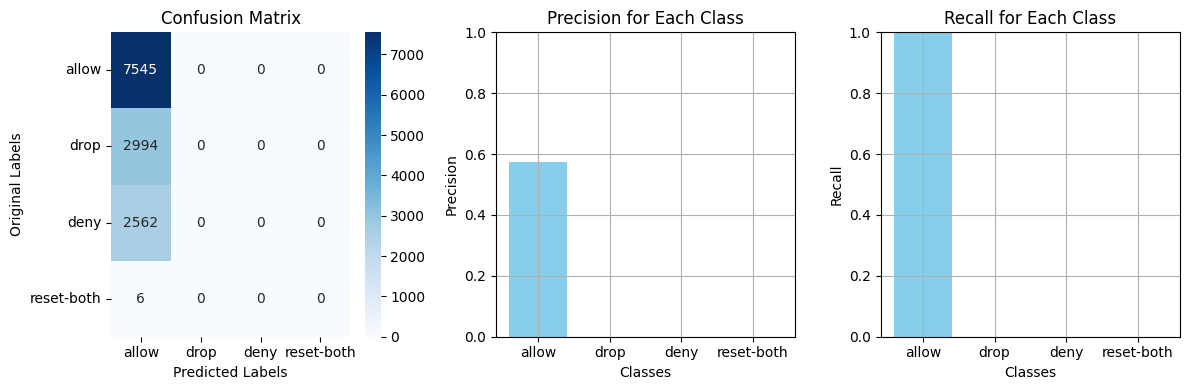

In [ ]:
# Instantiate and fit the DummyClassifier
dummy_classifier = DummyClassifier(strategy="stratified", random_state=42)
dummy_classifier.fit(X_train, y_train)

# Calibrate the dummy classifier on training data
calibrator_dummy = CalibratedClassifierCV(dummy_classifier, method='isotonic', cv='prefit')
calibrator_dummy.fit(X_train, y_train)

# Evaluate the dummy classifier on test data
dummy_classifier_train_probs = calibrator_dummy.predict_proba(X_train)
dummy_classifier_test_probs = calibrator_dummy.predict_proba(X_test)

# Calculate log loss on train and test data
train_loss_dummy = log_loss(y_train, dummy_classifier_train_probs, eps=1e-15)
test_loss_dummy = log_loss(y_test, dummy_classifier_test_probs, eps=1e-15)

# Display log loss on train and test data using f-strings
print(f"Log loss on Train Data using DummyClassifier Model: {train_loss_dummy}")
print(f"Log loss on Test Data using DummyClassifier Model: {test_loss_dummy}\n")

# Predict using calibrated dummy classifier on test data
y_test_preds_dummy = calibrator_dummy.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_dummy, labels)

Log loss on Train Data using Naive Bayes Model: 0.09563594303698099
Log loss on Test Data using Naive Bayes Model: 0.092258647879278



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


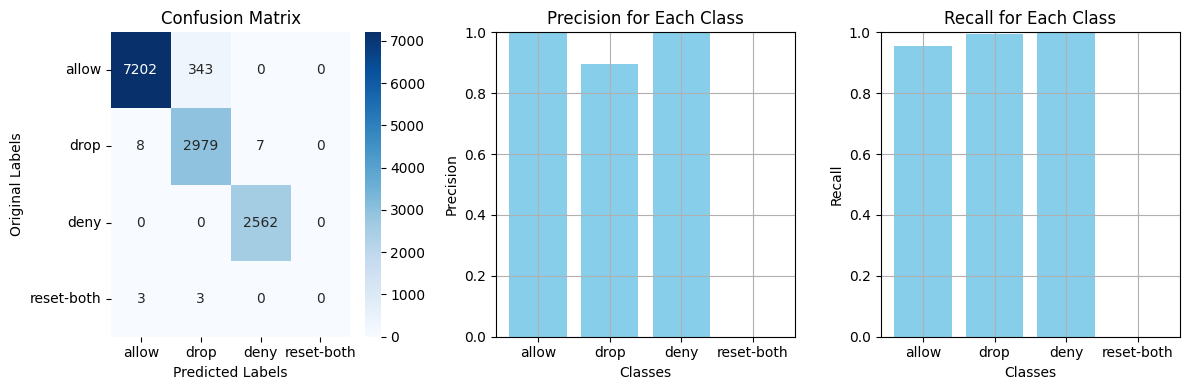

In [ ]:
# Instantiate and train the Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Calibrate the Naive Bayes classifier on training data
calibrator_nb = CalibratedClassifierCV(naive_bayes, method='isotonic', cv='prefit')
calibrator_nb.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_nb = calibrator_nb.predict_proba(X_train)
y_test_probs_nb = calibrator_nb.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_nb = log_loss(y_train, y_train_probs_nb)
test_loss_nb = log_loss(y_test, y_test_probs_nb)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using Naive Bayes Model: {train_loss_nb}")
print(f"Log loss on Test Data using Naive Bayes Model: {test_loss_nb}\n")

# Predict using calibrated Naive Bayes classifier on test data
y_test_preds_nb = calibrator_nb.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_nb, labels)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Log loss on Train Data using Logistic Regression Model: 0.20293817206973913
Log loss on Test Data using Logistic Regression Model: 0.20561598420192514



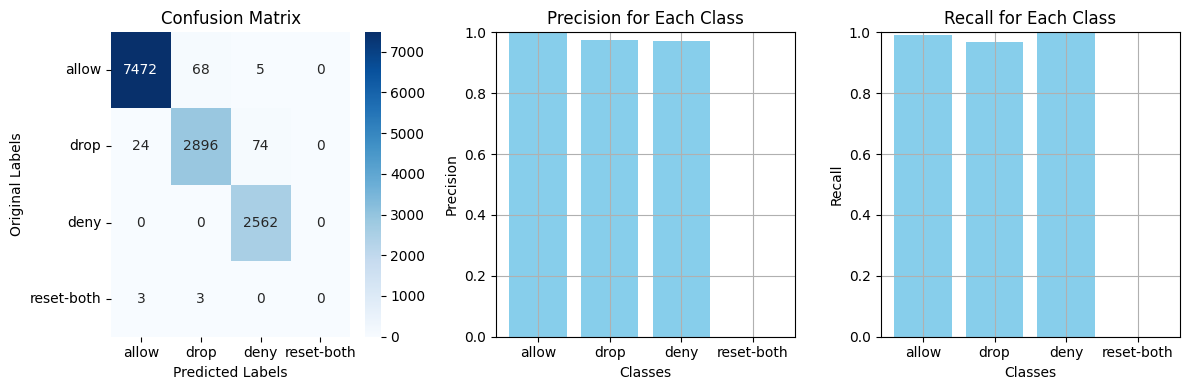

In [ ]:
# Instantiate and train the Logistic Regression classifier with increased max_iter
lr = LogisticRegression(C=10, random_state=859, max_iter=1000)
lr.fit(X_train, y_train)

# Calibrate the Logistic Regression classifier on training data
calibrator_lr = CalibratedClassifierCV(lr, method='isotonic', cv='prefit')
calibrator_lr.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_lr = calibrator_lr.predict_proba(X_train)
y_test_probs_lr = calibrator_lr.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_lr = log_loss(y_train, y_train_probs_lr)
test_loss_lr = log_loss(y_test, y_test_probs_lr)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using Logistic Regression Model: {train_loss_lr}")
print(f"Log loss on Test Data using Logistic Regression Model: {test_loss_lr}\n")

# Predict using calibrated Logistic Regression classifier on test data
y_test_preds_lr = calibrator_lr.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_lr, labels)


Log loss on Train Data using Decision Tree Model: 0.00043373133414818755
Log loss on Test Data using Decision Tree Model: 0.05838722365411246



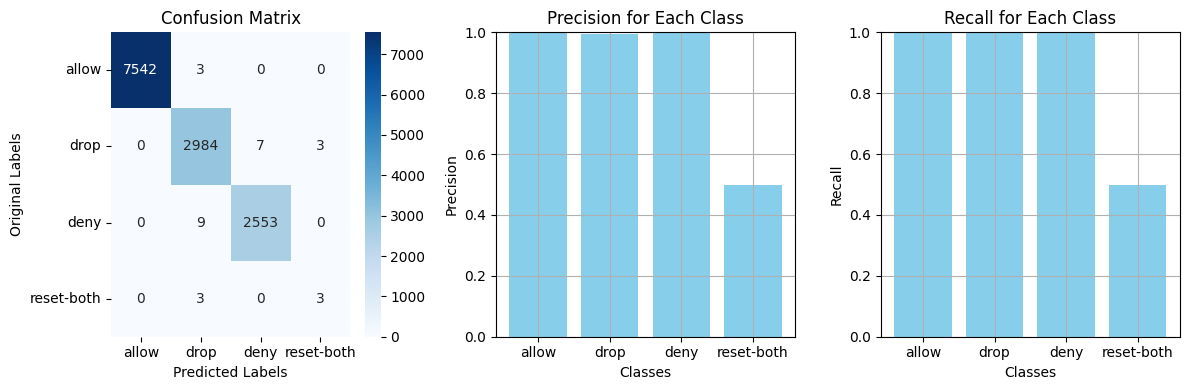

In [ ]:
# Instantiate and train the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=859, class_weight='balanced')
decision_tree.fit(X_train, y_train)

# Calibrate the Decision Tree classifier on training data
calibrator_dt = CalibratedClassifierCV(decision_tree, method='isotonic', cv='prefit')
calibrator_dt.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_dt = calibrator_dt.predict_proba(X_train)
y_test_probs_dt = calibrator_dt.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_dt = log_loss(y_train, y_train_probs_dt, eps=1e-15)
test_loss_dt = log_loss(y_test, y_test_probs_dt, eps=1e-15)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using Decision Tree Model: {train_loss_dt}")
print(f"Log loss on Test Data using Decision Tree Model: {test_loss_dt}\n")

# Predict using calibrated Decision Tree classifier on test data
y_test_preds_dt = calibrator_dt.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_dt, labels)

Log loss on Train Data using Gradient Boosting Model: 0.002996018627493403
Log loss on Test Data using Gradient Boosting Model: 0.007650664393207084



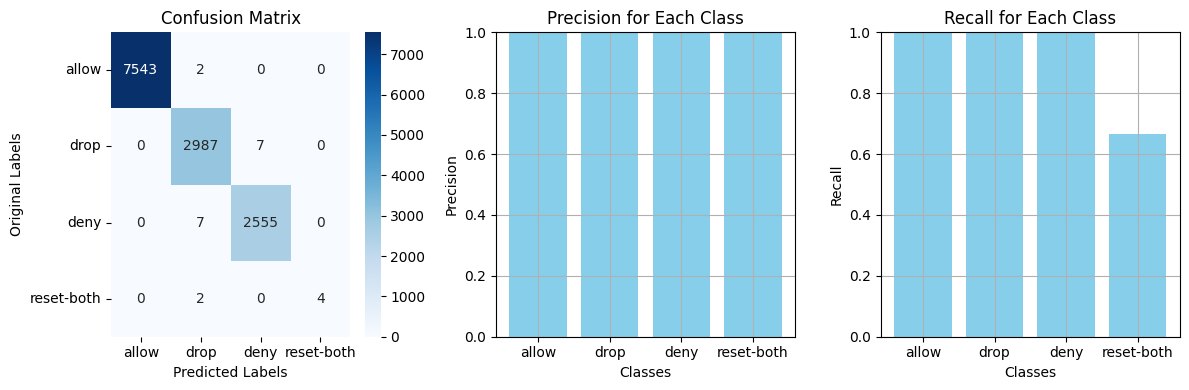

In [ ]:
# Instantiate and train the Gradient Boosting classifier
gradient_boosting = GradientBoostingClassifier(random_state=859)
gradient_boosting.fit(X_train, y_train)

# Calibrate the Gradient Boosting classifier on training data
calibrator_gb = CalibratedClassifierCV(gradient_boosting, method='isotonic', cv='prefit')
calibrator_gb.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_gb = calibrator_gb.predict_proba(X_train)
y_test_probs_gb = calibrator_gb.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_gb = log_loss(y_train, y_train_probs_gb, eps=1e-15)
test_loss_gb = log_loss(y_test, y_test_probs_gb, eps=1e-15)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using Gradient Boosting Model: {train_loss_gb}")
print(f"Log loss on Test Data using Gradient Boosting Model: {test_loss_gb}\n")

# Predict using calibrated Gradient Boosting classifier on test data
y_test_preds_gb = calibrator_gb.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_gb, labels)

Log loss on Train Data using AdaBoost Classifier Model: 0.01436956093634543
Log loss on Test Data using AdaBoost Classifier Model: 0.013994382213587361



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


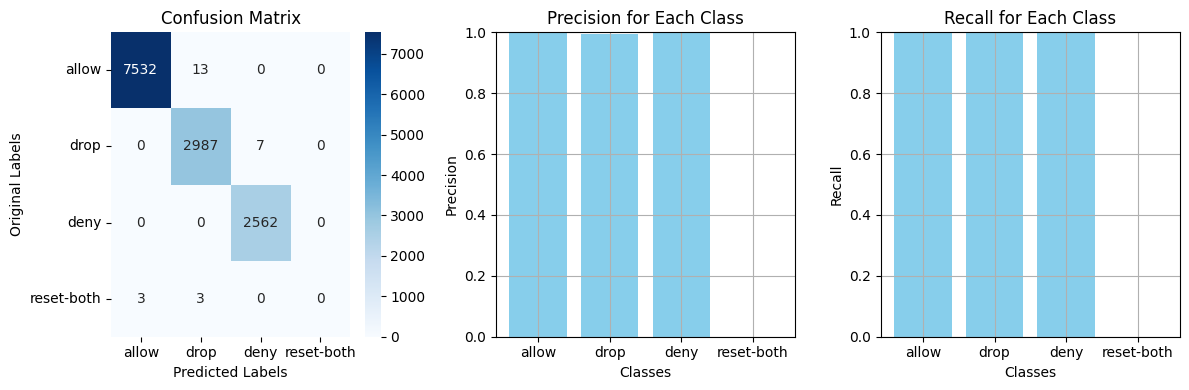

In [ ]:
# Instantiate and train the AdaBoost classifier
adaboost = AdaBoostClassifier(n_estimators=200, random_state=859)
adaboost.fit(X_train, y_train)

# Calibrate the AdaBoost classifier on training data
calibrator_adaboost = CalibratedClassifierCV(adaboost, method='isotonic', cv='prefit')
calibrator_adaboost.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_adaboost = calibrator_adaboost.predict_proba(X_train)
y_test_probs_adaboost = calibrator_adaboost.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_adaboost = log_loss(y_train, y_train_probs_adaboost, eps=1e-15)
test_loss_adaboost = log_loss(y_test, y_test_probs_adaboost, eps=1e-15)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using AdaBoost Classifier Model: {train_loss_adaboost}")
print(f"Log loss on Test Data using AdaBoost Classifier Model: {test_loss_adaboost}\n")

# Predict using calibrated AdaBoost classifier on test data
y_test_preds_adaboost = calibrator_adaboost.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_adaboost, labels)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Log loss on Train Data using XGBoost Classifier Model: 0.003360002606653292
Log loss on Test Data using XGBoost Classifier Model: 0.02329898512665044



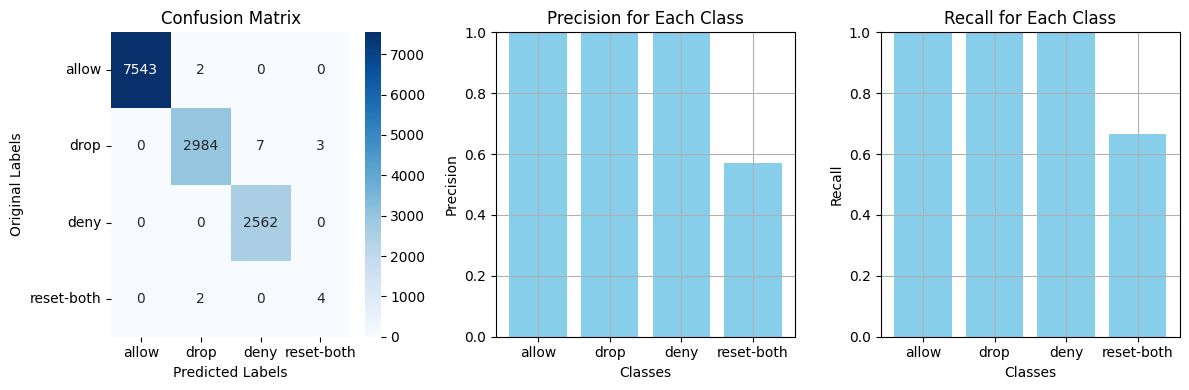

In [ ]:
# Instantiate and train the XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=750, max_depth=4, objective='multi:softmax', class_weight='balanced', random_state=859)
xgb_classifier.fit(X_train, y_train)

# Calibrate the XGBoost classifier on training data
calibrator_xgb = CalibratedClassifierCV(xgb_classifier, method='isotonic', cv='prefit')
calibrator_xgb.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_xgb = calibrator_xgb.predict_proba(X_train)
y_test_probs_xgb = calibrator_xgb.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_xgb = log_loss(y_train, y_train_probs_xgb, eps=1e-15)
test_loss_xgb = log_loss(y_test, y_test_probs_xgb, eps=1e-15)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using XGBoost Classifier Model: {train_loss_xgb}")
print(f"Log loss on Test Data using XGBoost Classifier Model: {test_loss_xgb}\n")

# Predict using calibrated XGBoost classifier on test data
y_test_preds_xgb = calibrator_xgb.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_xgb, labels)

Log loss on Train Data using Voting Classifier Model: 0.2663742309858073
Log loss on Test Data using Voting Classifier Model: 0.26622797437235746



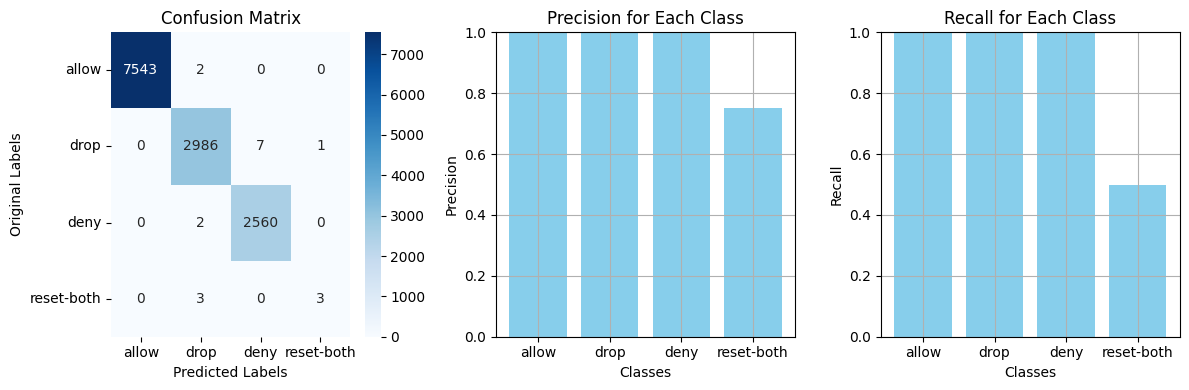

In [ ]:
# Instantiate individual classifiers
clf1 = DummyClassifier(strategy="stratified", random_state=859)
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(random_state=859, class_weight='balanced')
clf4 = GradientBoostingClassifier(random_state=859)
clf5 = AdaBoostClassifier(n_estimators=200, random_state=859)
clf6 = XGBClassifier(n_estimators=750, max_depth=4, objective='multi:softmax', random_state=859)
lr = LogisticRegression(C=10, random_state=859)

# Create a Voting Classifier with 'soft' voting
voting = VotingClassifier(
    estimators=[
        ('dummy', clf1),
        ('naive_bayes', clf2),
        ('decision_tree', clf3),
        ('gradient_boosting', clf4),
        ('adaboost', clf5),
        ('xgb', clf6),
    ],
    voting='soft',
    n_jobs=-1
)
voting.fit(X_train, y_train)

# Predict probabilities on training and test data
y_train_probs_voting = voting.predict_proba(X_train)
y_test_probs_voting = voting.predict_proba(X_test)

# Calculate log loss on training and test data
train_loss_voting = log_loss(y_train, y_train_probs_voting, eps=1e-15)
test_loss_voting = log_loss(y_test, y_test_probs_voting, eps=1e-15)

# Display log loss on training and test data using f-strings
print(f"Log loss on Train Data using Voting Classifier Model: {train_loss_voting}")
print(f"Log loss on Test Data using Voting Classifier Model: {test_loss_voting}\n")

# Predict using Voting Classifier on test data
y_test_preds_voting = voting.predict(X_test)

# Plot confusion matrix, precision, and recall for test data
plot_confusion_precision_recall(y_test, y_test_preds_voting, labels)

In [ ]:
def check(model, vector, num_runs=100):
    """
    Checks the run-time complexity of the model for a single log data. Gives the mean of test runs for reliability.
    Args:
        model: Instance of the ML model
        vector: Vector of log data
        num_runs: Number of test runs
    Returns:
        Mean run time of prediction
    """
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        pred = model.predict(vector)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
    return np.round(np.mean(times), 4)

# Storing run times for all the models in a dictionary
elapsed_times = {
    'Dummy Classifier': check(calibrator_dummy, X_test[:1]),
    'Naive Bayes Classifier': check(calibrator_nb, X_test[:1]),
    'Decision Tree Classifier': check(calibrator_dt, X_test[:1]),
    'Logistic Regression': check(calibrator_lr, X_test[:1]),
    'Gradient Boosting Classifier': check(calibrator_gb, X_test[:1]),
    'AdaBoost Classifier': check(calibrator_adaboost, X_test[:1]),
    'XGB Classifier': check(calibrator_xgb, X_test[:1]),
    'Voting Classifier': check(voting, X_test[:1]),
}

In [ ]:
classifiers = [
    ("Dummy Classifier", train_loss_dummy, test_loss_dummy, elapsed_times['Dummy Classifier']),
    ("Naive Bayes Classifier", train_loss_nb, test_loss_nb, elapsed_times['Naive Bayes Classifier']),
    ("Decision Tree Classifier", train_loss_dt, test_loss_dt, elapsed_times['Decision Tree Classifier']),
    ("Logistic Regression", train_loss_lr, test_loss_lr, elapsed_times['Logistic Regression']),
    ("Gradient Boosting Classifier", train_loss_gb, test_loss_gb, elapsed_times['Gradient Boosting Classifier']),
    ("AdaBoost Classifier", train_loss_adaboost, test_loss_adaboost, elapsed_times['AdaBoost Classifier']),
    ("XGB Classifier", train_loss_xgb, test_loss_xgb, elapsed_times['XGB Classifier']),
    ("Voting Classifier", train_loss_voting, test_loss_voting, elapsed_times['Voting Classifier']),
]

headers = ["Sr. No.", "Classifier", "Train Log-Loss", "Test Log-Loss", "Run-time (sec)"]

table_data = [
    [i + 1, *classifier[:]] for i, classifier in enumerate(classifiers)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════╤══════════════════════════════╤══════════════════╤═════════════════╤══════════════════╕
│   Sr. No. │ Classifier                   │   Train Log-Loss │   Test Log-Loss │   Run-time (sec) │
╞═══════════╪══════════════════════════════╪══════════════════╪═════════════════╪══════════════════╡
│         1 │ Dummy Classifier             │      0.982031    │      0.977931   │           0.0018 │
├───────────┼──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┤
│         2 │ Naive Bayes Classifier       │      0.0956359   │      0.0922586  │           0.0031 │
├───────────┼──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┤
│         3 │ Decision Tree Classifier     │      0.000433731 │      0.0583872  │           0.0031 │
├───────────┼──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┤
│         4 │ Logistic Regression          │      0.202938    │      0.205616   │          